In [1]:
from lxml import etree
import pandas as pd
import os
import rdflib
import urllib

%matplotlib inline

## Save everything as n3 files

In [2]:
fp_in = '/media/sf_VBox_Shared/CaseLaw/lido_rdf/2017-11-28-xml/'
fp_out = '/media/sf_VBox_Shared/CaseLaw/lido_rdf/2017-11-29-n3/'

In [5]:
fnames = [(os.path.join(fp_in, f), os.path.join(fp_out, f.replace('.xml', '.n3'))) for f in os.listdir(fp_in)]

In [6]:
def add_link(id_from, id_to, graph):
    ns_overheidrl = rdflib.Namespace("http://linkeddata.overheid.nl/terms/")
    graph.namespace_manager.bind('overheidrl', ns_overheidrl)
    
    types = sub_ref.attrib['type'].split(' ')
    
    label = sub_ref.attrib.get("label", "")

    # We have to come up with an uri for this link
    linkid = types[0] + urllib.parse.quote(id_from) + urllib.parse.quote(id_to)
    link_uri = rdflib.URIRef(linkid)
    graph.add( (link_uri, rdflib.RDF["type"], rdflib.URIRef("http://linkeddata.overheid.nl/terms/LinkAct")))

    for typ in types:
        graph.add((link_uri, ns_overheidrl.heeftLinktype, rdflib.URIRef(typ)))
    
    graph.add((link_uri, ns_overheidrl.linktVan, rdflib.URIRef(id_from)))
    graph.add((link_uri, ns_overheidrl.linktNaar, rdflib.URIRef(id_to)))


In [ ]:
for fn_in, fn_out in fnames:
    root = etree.parse(fn_in).getroot()
    graph = rdflib.Graph()

    for sub in list(root.iterchildren('subject')):
        sub_id = sub.attrib['id']
        s = rdflib.URIRef(sub_id)
        for el in sub.iterchildren():
            if len(el.nsmap ) > 0:
                nsmap_reversed = {el.nsmap[k]: k for k in el.nsmap}

                ns = el.tag.split('}')[0][1:]
                tag = el.tag.split('}')[1]
                value = el.text
                if value is not None:


                    if urllib.parse.urlparse(value).scheme == 'http':
                        o = rdflib.URIRef(value)
                    else:
                        o = rdflib.Literal(value)

                    n = rdflib.Namespace(ns)

                    graph.namespace_manager.bind(nsmap_reversed[ns], n)

                    graph.add( (s, n[tag], o) )
                    
        for inkomende_links in sub.iterchildren('inkomende-links'):
            for sub_ref in inkomende_links.iterchildren():
                id_from = sub_ref.attrib['idref']
                id_to = sub_id
                add_link(id_from, id_to, graph)
        for uitgaande_links in sub.iterchildren('uitgaande-links'):
            for sub_ref in uitgaande_links.iterchildren():
                id_to = sub_ref.attrib['idref']
                id_from = sub_id
                add_link(id_from, id_to, graph)
        
    graph.serialize(fn_out, format='n3')

In [162]:
for s,p,o in graph:
    print(s,p,o)

http://linkeddata.overheid.nl/terms/jurisprudentie/id/ECLI:NL:HR:2017:961 http://purl.org/dc/terms/modified 2017-06-06T15:54:35Z
http://linkeddata.overheid.nl/terms/bwb/id/BWBR0002320/2873934/2011-01-01/2009-01-01 http://linkeddata.overheid.nl/terms/kleur #007BC7
http://linkeddata.overheid.nl/terms/bwb/id/BWBR0002320/2873934/2011-01-01/2009-01-01 http://purl.org/dc/terms/identifier http://wetten.overheid.nl/id/BWBR0002320/2013-01-01/1/HoofdstukIII/Artikel16
http://linkeddata.overheid.nl/terms/jurisprudentie/id/ECLI:EU:C:2017:119 http://linkeddata.overheid.nl/terms/volgorde 6000
http://linkeddata.overheid.nl/terms/bwb/id/BWBR0002320/2873934/2011-01-01/2009-01-01 http://linkeddata.overheid.nl/terms/heeftJuriconnect 1.0:c:BWBR0002320&artikel=16&g=2016-04-01
http://linkeddata.overheid.nl/terms/bwb/id/BWBR0002320/2873934/2011-01-01/2009-01-01 http://purl.org/dc/terms/identifier http://wetten.overheid.nl/id/BWBR0002320/2012-01-01/0/HoofdstukIII/Artikel16
http://linkeddata.overheid.nl/terms/b

In [140]:
for inkomende_links in sub.iterchildren('inkomende-links'):
    for sub_ref in inkomende_links.iterchildren():
            
            links.append(get_links_from_incoming(sub_ref, sub_dict['id']))
    for uitgaande_links in sub.iterchildren('uitgaande-links'):
        for sub_ref in uitgaande_links.iterchildren():
            links.append(get_links_from_outgoing(sub_ref, sub_dict['id']))

IndentationError: unindent does not match any outer indentation level (<ipython-input-140-8d3ef0bff14c>, line 5)

In [44]:
def get_links_from_outgoing(sub_ref, source_id):
    return {
            'target_id': sub_ref.attrib['idref'],
            'link_type': sub_ref.attrib['type'],
            'source_id': source_id
            }

def get_links_from_incoming(sub_ref, target_id):
    return {
            'source_id': sub_ref.attrib['idref'],
            'link_type': sub_ref.attrib['type'],
            'target_id': target_id,
            }

In [50]:
links = []
nodes = []

single_attr_list = ['type', 'title', 'creator', 'modified']

for sub in list(root.iterchildren('subject')):
    sub_dict = {}
    sub_dict['id'] = sub.attrib['id']

    for att in single_attr_list:
         for s in sub.iterchildren('{*}'+att):
                sub_dict[att] = s.text
                

    nodes.append(sub_dict)

    for inkomende_links in sub.iterchildren('inkomende-links'):
        for sub_ref in inkomende_links.iterchildren():
            links.append(get_links_from_incoming(sub_ref, sub_dict['id']))
    for uitgaande_links in sub.iterchildren('uitgaande-links'):
        for sub_ref in uitgaande_links.iterchildren():
            links.append(get_links_from_outgoing(sub_ref, sub_dict['id']))

                
links_df = pd.DataFrame.from_dict(links)
nodes_df = pd.DataFrame.from_dict(nodes)

links_df = links_df.drop_duplicates()
nodes_df = nodes_df.drop_duplicates()

In [52]:
nodes_df.sort_values('title')

,creator,id,modified,title,type
1,NaN,http://linkeddata.overheid.nl/terms/bwb/id/BWB...,2016-01-01T00:00:00Z,Burgerlijk Wetboek Boek 8,Wet
2,NaN,http://linkeddata.overheid.nl/terms/bwb/id/BWB...,2005-06-01T00:00:00Z,"Burgerlijk Wetboek Boek 8, Artikel 1401",Wet
0,Hoge Raad der Nederlanden,http://linkeddata.overheid.nl/terms/jurisprude...,2016-11-05T18:30:04Z,"ECLI:NL:HR:1988:AD5713 - Hoge Raad, 23-09-1988...",Jurisprudentie
3,NaN,http://linkeddata.overheid.nl/terms/jurisprude...,2016-09-18T00:05:44Z,ECLI:NL:PHR:1988:AD5713 - Parket bij de Hoge R...,Jurisprudentie
5,NaN,http://linkeddata.overheid.nl/terms/jurisprude...,2017-06-01T22:15:48Z,ECLI:NL:PHR:2004:AM2312 - Parket bij de Hoge R...,Jurisprudentie
6,NaN,http://linkeddata.overheid.nl/terms/jurisprude...,2017-06-01T22:27:10Z,ECLI:NL:PHR:2004:AP1872 - Parket bij de Hoge R...,Jurisprudentie
7,NaN,http://linkeddata.overheid.nl/terms/jurisprude...,2017-06-01T22:31:05Z,ECLI:NL:PHR:2005:AR3151 - Parket bij de Hoge R...,Jurisprudentie
8,NaN,http://linkeddata.overheid.nl/terms/jurisprude...,2017-06-01T22:43:38Z,ECLI:NL:PHR:2005:AT8823 - Parket bij de Hoge R...,Jurisprudentie
9,NaN,http://linkeddata.overheid.nl/terms/jurisprude...,2017-08-14T13:57:09Z,ECLI:NL:PHR:2007:BB3670 - Parket bij de Hoge R...,Jurisprudentie
10,NaN,http://linkeddata.overheid.nl/terms/jurisprude...,2016-09-15T10:27:55Z,ECLI:NL:PHR:2012:BX8349 - Parket bij de Hoge R...,Jurisprudentie


In [53]:
links_df

,link_type,source_id,target_id
0,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
1,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
2,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
3,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
4,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
5,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
6,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
7,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
8,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...
9,http://linkeddata.overheid.nl/terms/linktype/i...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/jurisprude...


In [55]:
import networkx as nx

In [56]:
g = nx.DiGraph()

In [59]:
for l in links:
    source = l['source_id'].split('/')[-1]
    target = l['target_id'].split('/')[-1]
    link_type = l['link_type'].split('/')[-1]
    g.add_edge(source, target, {'link_type': link_type})

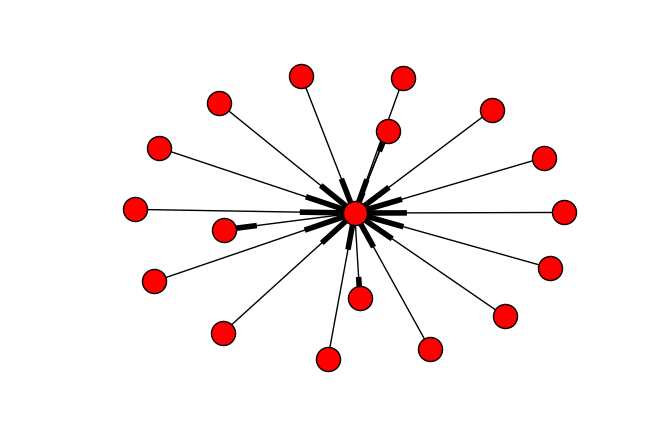

In [62]:
nx.draw(g)